In [1558]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline

In [1559]:
data = pd.read_csv('Spectrum_with_biochemical_traits_outlier_removal.csv')
data_2 = pd.read_csv('Raw_spectrum_merged.csv')
data_3 = pd.read_csv("agronomic_gt_only.csv")
data_2= data_2.loc[:, ['PLOT ID']]
data = pd.merge(data_2, data)
data = pd.merge(data_3, data)
data = data.loc[(data['350'].notnull()) , : ] #  & (data['Group'] == 'Hybrid'), :]

In [1560]:
data.columns[0:18]

Index(['PLOT ID', 'SLA', 'LWC', 'CHL', '% N', '% P', '% K', '% S', '% Ca',
       '% Mg', 'ppm Zn', 'ppm Fe', 'ppm Mn', 'ppm Cu', 'ppm B', 'ppm Mo',
       'rows', 'ranges'],
      dtype='object')

In [1561]:
trait = 'ppm Mo'

In [1562]:
data_PLSR = data.loc[(data[trait].notnull()) & (data['350'].notnull()), :] # & (data['Trt'] == 'HN'), : ] 

In [1563]:
## Selecting group and treatment to follow the labels
labels = data_PLSR.loc[: , ['Group', 'Trt']].reset_index(drop=True)

In [1564]:
labels

,Group,Trt
0,Inbred,HN
1,Inbred,HN
2,Inbred,HN
3,Inbred,HN
4,Inbred,HN
...,...,...
307,Hybrid,HN
308,Hybrid,HN
309,Hybrid,HN
310,Hybrid,HN


In [1565]:
data_PLSR.columns[0:20]

Index(['PLOT ID', 'SLA', 'LWC', 'CHL', '% N', '% P', '% K', '% S', '% Ca',
       '% Mg', 'ppm Zn', 'ppm Fe', 'ppm Mn', 'ppm Cu', 'ppm B', 'ppm Mo',
       'rows', 'ranges', 'Block', 'Rep'],
      dtype='object')

In [1566]:
pos_350 = data_PLSR.columns.get_loc('350')
pos_2500 = data_PLSR.columns.get_loc('2500')
X = data_PLSR.iloc[:, pos_350:pos_2500]

In [1567]:
#Extracting the column names
col_names=X.columns

In [1568]:
#applying savitzky golay
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns=col_names)

In [1569]:
#drop first 100 column
X = X.drop(X.columns[0:100], axis=1)

In [1570]:
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)

In [1571]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]

In [1572]:
#PLOT ID column was added again for merging 
#X.insert(0, 'PLOT ID', np.array(data_PLSR['PLOT ID']))

In [1573]:
y = data_PLSR.loc[: , trait].reset_index(drop=True)

In [1574]:
# split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3)

In [1575]:
pd.merge(labels, X_train, left_index=True, right_index=True)

,Group,Trt,450,455,460,465,470,475,480,485,...,2450,2455,2460,2465,2470,2475,2480,2485,2490,2495
0,Inbred,HN,0.035496,0.036285,0.036419,0.036677,0.036848,0.036885,0.036963,0.037299,...,0.046002,0.044459,0.042922,0.041521,0.040042,0.038764,0.037882,0.036749,0.035767,0.035112
3,Inbred,HN,0.051964,0.052644,0.052834,0.052683,0.052341,0.052138,0.052218,0.052701,...,0.057661,0.055366,0.053368,0.051305,0.049344,0.047730,0.046194,0.044849,0.043749,0.042685
4,Inbred,HN,0.053957,0.055385,0.055300,0.055314,0.055493,0.055750,0.055841,0.056223,...,0.058700,0.057561,0.056364,0.055173,0.053919,0.052950,0.052544,0.052102,0.051315,0.050781
5,Inbred,HN,0.039537,0.040387,0.040368,0.040519,0.041065,0.040819,0.040880,0.041399,...,0.047269,0.045437,0.044465,0.042950,0.041319,0.040629,0.039683,0.038914,0.038143,0.038376
6,Inbred,HN,0.047849,0.048807,0.048794,0.048968,0.049244,0.049307,0.049404,0.049927,...,0.064819,0.062956,0.061365,0.059849,0.058089,0.056627,0.055872,0.054431,0.053527,0.053002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Hybrid,HN,0.040160,0.041175,0.041262,0.041407,0.041611,0.041664,0.041808,0.042185,...,0.063389,0.061305,0.059031,0.057308,0.055622,0.054148,0.052752,0.051110,0.050685,0.049378
308,Hybrid,HN,0.039583,0.040137,0.040261,0.040273,0.040371,0.040501,0.040443,0.040747,...,0.054859,0.053143,0.051391,0.050009,0.048248,0.047225,0.045835,0.045225,0.044159,0.043247
309,Hybrid,HN,0.040473,0.041395,0.041860,0.041829,0.041986,0.042107,0.042332,0.042838,...,0.067603,0.065332,0.063273,0.061116,0.059545,0.057473,0.055754,0.054691,0.053247,0.052504
310,Hybrid,HN,0.040597,0.041314,0.041438,0.041523,0.041708,0.041685,0.041875,0.042279,...,0.068108,0.065816,0.063957,0.062021,0.060217,0.058768,0.057140,0.056466,0.055024,0.054189


In [1576]:
cv = RepeatedKFold(n_splits=10, n_repeats=5)
mse = []

In [1577]:
#Calculate MSE using cross-validation, adding one component at a time
cv = RepeatedKFold(n_repeats=10, n_splits=10, random_state=None)
for i in np.arange(1, 35):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(np.sqrt(score))
    n_comb = mse.index(min(mse)) +1

Text(0.5, 1.0, 'ppm Mo')

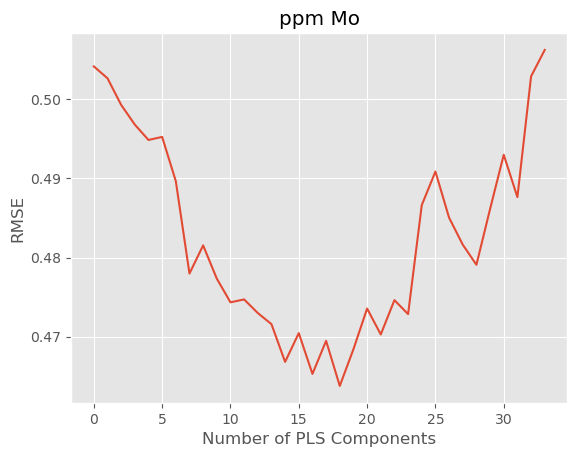

In [1578]:
#plot test RMSE vs. number of components
plt.style.use('ggplot')
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title(trait)

In [1579]:
### calculate RMSE
pls = PLSRegression(n_components=n_comb)
pls.fit(X_train, y_train)

PLSRegression(n_components=19)

In [1580]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

0.43729147771727755

In [1581]:
y_pred = pls.predict(X_test)

In [1582]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r ,r2, p)

0.3496661705033178 0.1222664307944553 0.0005513050087719518


In [1583]:
## adding labels to y_pred first add to X_test then transfer it to y_pred
y_pred=pd.DataFrame(y_pred, columns=[trait + '_predicted'])
X_test= pd.merge(labels, X_test, left_index=True, right_index=True).reset_index()
y_pred['Group'] = X_test['Group']
y_pred['Trt'] = X_test['Trt']
y_test.reset_index(drop=True, inplace=True) 
y_pred[trait + '_gt'] = y_test

In [1584]:
y_pred_inb = y_pred.loc[y_pred['Group'] == 'Inbred', :]
r_inbred,p_inbred = spearmanr(y_pred_inb[trait + '_predicted'] , y_pred_inb[trait + '_gt'])
r2_inbred= r_inbred**2
y_pred_hyb = y_pred.loc[y_pred['Group'] == 'Hybrid', :]
r_hybrid,p_hybrid = spearmanr(y_pred_hyb[trait + '_predicted'] , y_pred_hyb[trait + '_gt'])
r2_hybrid= r_hybrid**2

In [1585]:
r2_combined = [r2_inbred, r2_hybrid]

Text(0.3, 0.9, 'r2 =0.12')

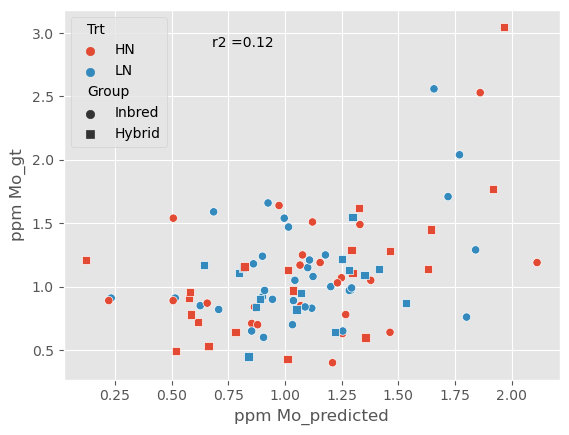

In [1586]:
#sns.regplot(x = trait + '_predicted'  , y = trait + '_gt', data=y_pred)
sns.scatterplot(x=trait + '_predicted', y= trait + '_gt' , data=y_pred , hue='Trt', style='Group', markers=['o', 's'])
ax=plt.gca()
plt.text(.3 , .9, 'r2 =' + str(r2.round(2)), transform=ax.transAxes)

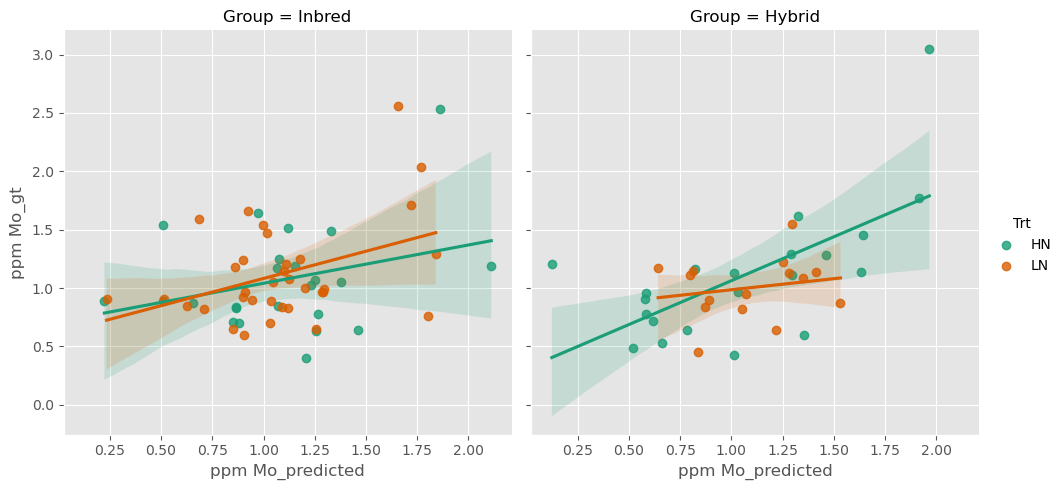

In [1587]:
g =sns.lmplot(data = y_pred, x = trait + '_predicted', y = trait + '_gt', hue = 'Trt', palette = 'Dark2',
       fit_reg = True, col='Group', height = 5, aspect= 1)


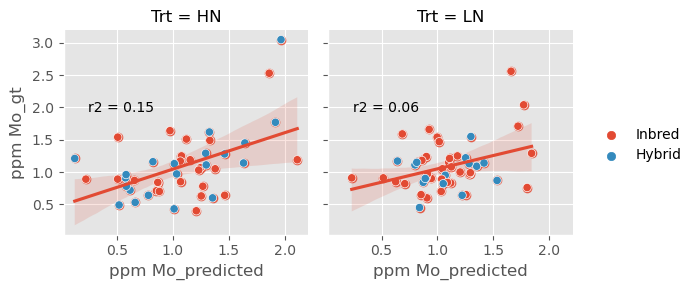

In [1588]:
import matplotlib.pyplot as plt
def annotate(data, **kws):
    r,p = spearmanr(data[trait + '_predicted'], data[trait + '_gt'])
    r2 = (r**2).round(2)
    ax = plt.gca()
    ax.text(.1, .6, f"r2 = {r2}", transform=ax.transAxes)

g = sns.FacetGrid(y_pred, col="Trt")
g.map_dataframe(sns.regplot, x=trait + '_predicted', y=trait + '_gt')
g.map_dataframe(sns.scatterplot, x=trait + '_predicted', y=trait + '_gt' , hue='Group')
g.add_legend()
g.map_dataframe(annotate)

plt.scatter(y_test, y_pred)
plt.ylabel('Predicted' + ' ' + trait + ' ' + 'values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)
#plt.text(x=8, y=12.8 , s='r$^2$ = 0.06')

In [1589]:
pls = PLSRegression(n_components=n_comb)
score = model_selection.cross_val_score(pls, X, y, cv=cv).mean()

In [1590]:
# from math import sqrt
score

0.06463148610001758

# Predicting whole dataset

In [1591]:
data = pd.read_csv('Spectrum_with_biochemical_traits_outlier_removal.csv')
data_2 = pd.read_csv('Raw_spectrum_merged.csv')
data_3 = pd.read_csv("agronomic_gt_only.csv")
data_2= data_2.loc[:, ['PLOT ID']]
data = pd.merge(data_2, data)
data = pd.merge(data_3, data)
data = data.loc[(data['350'].notnull()), :] #& (data['Group'] == 'Inbred')


In [1592]:
data

,PLOT ID,SLA,LWC,CHL,% N,% P,% K,% S,% Ca,% Mg,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035234,0.035088,0.034933,0.034826,0.034614,0.034352,0.034138,0.033865,0.033638,0.033476
1,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037554,0.037249,0.037154,0.037163,0.037074,0.037141,0.037005,0.036618,0.036303,0.035844
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.042723,0.042242,0.042083,0.041943,0.041776,0.041955,0.041835,0.041389,0.041090,0.040662
3,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.041980,0.041998,0.041733,0.041467,0.041499,0.041415,0.041049,0.041078,0.041080,0.040855
4,1005,210.344828,77.490298,NaN,3.521,0.402,1.74,0.308,0.478,0.198,...,0.035746,0.035719,0.035662,0.035373,0.035116,0.034928,0.034894,0.035089,0.035207,0.035318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,4596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.059570,0.059487,0.059379,0.059312,0.059066,0.058804,0.058750,0.058499,0.058298,0.058202
2396,4597,148.738739,73.285199,536.6,3.526,0.377,1.86,0.266,0.515,0.253,...,0.045764,0.045825,0.045893,0.045686,0.045541,0.045311,0.045272,0.045472,0.045199,0.045085
2397,4598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.056652,0.056354,0.056035,0.055800,0.055557,0.055148,0.054880,0.054803,0.054617,0.054308
2398,4599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.050402,0.050328,0.050200,0.049665,0.049339,0.049328,0.049174,0.048901,0.048625,0.048320


In [1593]:
pos_350 = data.columns.get_loc('350')
pos_2500 = data.columns.get_loc('2500')
train = data.loc[data[trait].notnull() , :]
X_train = train.iloc[:, pos_350:pos_2500]
y_train = train.loc[:, trait]

In [1594]:
X_train_index = X_train.index

In [1595]:
X_train_index

Int64Index([   4,    6,   18,   60,  153,  155,  156,  198,  199,  202,
            ...
            2376, 2382, 2383, 2384, 2385, 2386, 2388, 2389, 2390, 2396],
           dtype='int64', length=312)

In [1596]:
#Extracting the column names
col_names=X_train.columns
#applying savitzky golay
X_train = savgol_filter(X_train, window_length=5 , polyorder = 2)
X_train = pd.DataFrame(X_train, columns=col_names)
#drop first 100 column
X_train = X_train.drop(X_train.columns[0:100], axis=1)
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)
# Choose from the X based on filtering array
X_train = X_train.iloc[: , column_filter]
X_train.set_index(X_train_index, inplace=True)

In [1597]:
X_train

,450,455,460,465,470,475,480,485,490,495,...,2450,2455,2460,2465,2470,2475,2480,2485,2490,2495
4,0.035496,0.036285,0.036419,0.036677,0.036848,0.036885,0.036963,0.037299,0.038144,0.039155,...,0.046002,0.044459,0.042922,0.041521,0.040042,0.038764,0.037882,0.036749,0.035767,0.035112
6,0.051669,0.053216,0.053859,0.053814,0.054149,0.054459,0.054598,0.055209,0.056733,0.058923,...,0.078403,0.076053,0.073855,0.071431,0.069493,0.067616,0.066283,0.065054,0.063237,0.061748
18,0.049999,0.050574,0.050352,0.050312,0.050332,0.050178,0.050253,0.050561,0.050808,0.051360,...,0.055989,0.054565,0.053394,0.051987,0.050874,0.049819,0.049170,0.048072,0.047340,0.047082
60,0.051964,0.052644,0.052834,0.052683,0.052341,0.052138,0.052218,0.052701,0.053500,0.054865,...,0.057661,0.055366,0.053368,0.051305,0.049344,0.047730,0.046194,0.044849,0.043749,0.042685
153,0.053957,0.055385,0.055300,0.055314,0.055493,0.055750,0.055841,0.056223,0.057060,0.058567,...,0.058700,0.057561,0.056364,0.055173,0.053919,0.052950,0.052544,0.052102,0.051315,0.050781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386,0.043200,0.044065,0.044361,0.044530,0.044704,0.044728,0.044865,0.045290,0.046082,0.047413,...,0.059297,0.057304,0.055618,0.054255,0.052254,0.051160,0.050028,0.048961,0.048075,0.047927
2388,0.039583,0.040137,0.040261,0.040273,0.040371,0.040501,0.040443,0.040747,0.041213,0.042059,...,0.054859,0.053143,0.051391,0.050009,0.048248,0.047225,0.045835,0.045225,0.044159,0.043247
2389,0.040473,0.041395,0.041860,0.041829,0.041986,0.042107,0.042332,0.042838,0.043725,0.045259,...,0.067603,0.065332,0.063273,0.061116,0.059545,0.057473,0.055754,0.054691,0.053247,0.052504
2390,0.040597,0.041314,0.041438,0.041523,0.041708,0.041685,0.041875,0.042279,0.042998,0.044232,...,0.068108,0.065816,0.063957,0.062021,0.060217,0.058768,0.057140,0.056466,0.055024,0.054189


In [1598]:
y_train = train.loc[: , trait]

In [1599]:
y_train

4       1.26
6       0.91
18      0.78
60      0.86
153     1.18
        ... 
2386    1.13
2388    1.25
2389    1.46
2390    1.19
2396    0.88
Name: ppm Mo, Length: 312, dtype: float64

In [1600]:
test= data.loc[data[trait].isnull(), :]
X_test = test.iloc[:, pos_350:pos_2500]
y_test = test.loc[:, trait]

In [1601]:
X_test_index= X_test.index

In [1602]:
X_test_index

Int64Index([   0,    1,    2,    3,    5,    7,    8,    9,   10,   11,
            ...
            2381, 2387, 2391, 2392, 2393, 2394, 2395, 2397, 2398, 2399],
           dtype='int64', length=2066)

In [1603]:
#Extracting the column names
col_names=X_test.columns
#applying savitzky golay
X_test = savgol_filter(X_test, window_length=5 , polyorder = 2)
X_test = pd.DataFrame(X_test, columns=col_names)
#drop first 100 column
X_test = X_test.drop(X_test.columns[0:100], axis=1)
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)
# Choose from the X based on filtering array
X_test = X_test.iloc[: , column_filter]
X_test.set_index(X_test_index, inplace=True)

In [1604]:
y_test=test.loc[:, trait]
y_test = y_test.to_frame(name=trait)

In [1605]:
y_test

,ppm Mo
0,NaN
1,NaN
2,NaN
3,NaN
5,NaN
...,...
2394,NaN
2395,NaN
2397,NaN
2398,NaN


In [1606]:
pls = PLSRegression(n_components=n_comb)
score = model_selection.cross_val_score(pls, X_train, y_train, cv=cv).mean()
score

0.07339172454996873

In [1607]:
pls = PLSRegression(n_components=n_comb)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

In [1608]:
y_test[trait] = y_pred

In [1609]:
y_test_index = y_test.index.values

In [1610]:
y_test_index[0:20]

array([ 0,  1,  2,  3,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
       20, 21, 22])

data = pd.read_csv('Spectrum_with_biochemical_traits_outlier_removal.csv')
data_2 = pd.read_csv('Raw_spectrum_merged.csv')
data_3 = pd.read_csv("agronomic_gt_only.csv")
data_2= data_2.loc[:, ['PLOT ID']]
data = pd.merge(data_2, data)
data_predicted = pd.merge(data_3, data)

In [1611]:
data_predicted.loc[y_test_index, trait] = y_test[trait]

In [1612]:
data_predicted

,PLOT ID,SLA,LWC,CHL,% N,% P,% K,% S,% Ca,% Mg,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1001,213.548688,80.494345,278.389554,2.922769,0.372214,2.116404,0.187241,0.389935,0.236830,...,0.035234,0.035088,0.034933,0.034826,0.034614,0.034352,0.034138,0.033865,0.033638,0.033476
1,1002,186.063875,77.880225,383.077772,2.875683,0.351035,2.017486,0.222424,0.490029,0.180783,...,0.037554,0.037249,0.037154,0.037163,0.037074,0.037141,0.037005,0.036618,0.036303,0.035844
2,1003,182.767345,75.674337,277.703004,2.358233,0.344221,2.072015,0.189670,0.473434,0.199683,...,0.042723,0.042242,0.042083,0.041943,0.041776,0.041955,0.041835,0.041389,0.041090,0.040662
3,1004,196.152010,76.388422,396.656937,3.142999,0.359627,1.885271,0.224698,0.408551,0.188440,...,0.041980,0.041998,0.041733,0.041467,0.041499,0.041415,0.041049,0.041078,0.041080,0.040855
4,1005,210.344828,77.490298,370.780925,3.521000,0.402000,1.740000,0.308000,0.478000,0.198000,...,0.035746,0.035719,0.035662,0.035373,0.035116,0.034928,0.034894,0.035089,0.035207,0.035318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,4596,156.075451,71.180102,517.591685,3.354245,0.324472,1.644651,0.241666,0.504383,0.271812,...,0.059570,0.059487,0.059379,0.059312,0.059066,0.058804,0.058750,0.058499,0.058298,0.058202
2396,4597,148.738739,73.285199,536.600000,3.526000,0.377000,1.860000,0.266000,0.515000,0.253000,...,0.045764,0.045825,0.045893,0.045686,0.045541,0.045311,0.045272,0.045472,0.045199,0.045085
2397,4598,147.303759,72.290501,524.308812,3.600508,0.396007,1.788047,0.253576,0.713514,0.201040,...,0.056652,0.056354,0.056035,0.055800,0.055557,0.055148,0.054880,0.054803,0.054617,0.054308
2398,4599,144.393197,71.637782,504.277877,3.184901,0.356666,1.885522,0.243842,0.678665,0.244404,...,0.050402,0.050328,0.050200,0.049665,0.049339,0.049328,0.049174,0.048901,0.048625,0.048320


In [1614]:
data_bio = data_predicted

In [1623]:
data_2 = pd.read_csv('Raw_spectrum_merged.csv')
data_3= data_2.loc[:, ['PLOT ID', 'Rep', 'Group', 'genotype', 'Trt']]

In [1628]:
data_son = pd.merge(data_3, data_bio, how='outer')

In [ ]:
data2[trait][0:20]

In [1630]:
data_son.to_csv('Spectrum_with_biochemical_all_predicted.csv' , index = False)

In [ ]:
## Outlier treatment

In [ ]:
#defining a function to remove the outliers
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1=datacolumn.quantile(0.25)
 Q3=datacolumn.quantile(0.75)
 #Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [ ]:
data = pd.merge(data_2, bio)

In [ ]:
'''
data.iloc[: , 0:17]
'''

In [ ]:
'''
data.to_csv('Spectrum_with_biochemical_all_predicted.csv' , index = False)
'''